In [77]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import os,sys
import imageio
from PIL import Image

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import optimizers
from keras.layers import BatchNormalization
from tensorflow.keras.metrics import MeanIoU
from keras import backend as K
import keras
import random

from sklearn.model_selection import train_test_split

#from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from datetime import datetime

## Constants

In [58]:
IMG_WIDTH = 400
IMG_HEIGHT = 400
EPOCHS = 100
LEARNING_RATE = 0.0001
BATCH_SIZE = 16
rnd_seed = 4

## Load Images

Loading 100 images


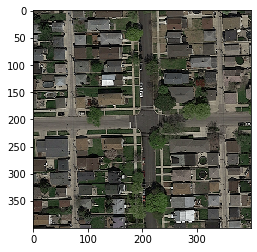

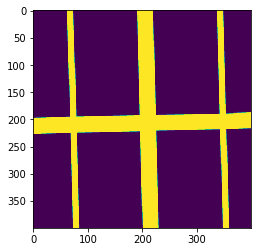

(100, 400, 400, 3)
(100, 400, 400, 1)


In [49]:
# First load data
training_input_dir = "training/images/"
training_label_dir = "training/groundtruth/"

print("Loading " + str(n) + " images")
files_input = os.listdir(training_input_dir)
files_label = os.listdir(training_label_dir)
n = len(files_input)

# Load real images and show some of them
training_input_img = [Image.open(training_input_dir + files[i]) for i in range(n)]
training_label_img = [Image.open(training_label_dir + files[i]) for i in range(n)]
plt.imshow(training_input_img[0])
plt.show()
plt.imshow(training_label_img[0])
plt.show()

# Load numpy arrays of images
training_input_list = [imageio.imread(training_input_dir + files[i]) for i in range(n)]
training_label_list = [imageio.imread(training_label_dir + files[i]) for i in range(n)]
training_input = np.array(training_input_list)
training_label = np.expand_dims(np.array(training_label_list), -1)

print(training_input.shape)
print(training_label.shape)

## Loss Function and Accuracy Metric
- Accuracy: Intersection of prediction to label image over Union
- Loss : Soft Dice Loss (Measure of interleaving of prediction image and label image)

Source: https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99

In [64]:
from keras import backend as K
def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  
  return iou

In [65]:
def dice_coef(y_true, y_pred, smooth = 1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def soft_dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

## Model: Fully CNN built in Keras

In [52]:
inputs = Input((IMG_HEIGHT, IMG_WIDTH, 3))
s = Lambda(lambda x: x / 400) (inputs)

conv1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
conv1 = BatchNormalization() (conv1)
conv1 = Dropout(0.1) (conv1)
conv1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1)
conv1 = BatchNormalization() (conv1)
pooling1 = MaxPooling2D((2, 2)) (conv1)

conv2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling1)
conv2 = BatchNormalization() (conv2)
conv2 = Dropout(0.1) (conv2)
conv2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2)
conv2 = BatchNormalization() (conv2)
pooling2 = MaxPooling2D((2, 2)) (conv2)

conv3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling2)
conv3 = BatchNormalization() (conv3)
conv3 = Dropout(0.2) (conv3)
conv3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3)
conv3 = BatchNormalization() (conv3)
pooling3 = MaxPooling2D((2, 2)) (conv3)

conv4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling3)
conv4 = BatchNormalization() (conv4)
conv4 = Dropout(0.2) (conv4)
conv4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv4)
conv4 = BatchNormalization() (conv4)
pooling4 = MaxPooling2D(pool_size=(2, 2)) (conv4)

conv5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling4)
conv5 = BatchNormalization() (conv5)
conv5 = Dropout(0.3) (conv5)
conv5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv5)
conv5 = BatchNormalization() (conv5)


upsample6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (conv5)
upsample6 = concatenate([upsample6, conv4])
conv6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample6)
conv6 = BatchNormalization() (conv6)
conv6 = Dropout(0.2) (conv6)
conv6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv6)
conv6 = BatchNormalization() (conv6)

upsample7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (conv6)
upsample7 = concatenate([upsample7, conv3])
conv7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample7)
conv7 = BatchNormalization() (conv7)
conv7 = Dropout(0.2) (conv7)
conv7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv7)
conv7 = BatchNormalization() (conv7)

upsample8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (conv7)
upsample8 = concatenate([upsample8, conv2])
conv8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample8)
conv8 = BatchNormalization() (conv8)
conv8 = Dropout(0.1) (conv8)
conv8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv8)
conv8 = BatchNormalization() (conv8)

upsample9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (conv8)
upsample9 = concatenate([upsample9, conv1], axis=3)
conv9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample9)
conv9 = BatchNormalization() (conv9)
conv9 = Dropout(0.1) (conv9)
conv9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv9)
conv9 = BatchNormalization() (conv9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (conv9)

model = Model(inputs=[inputs], outputs=[outputs])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 400, 400, 3)  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 400, 400, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 400, 400, 16) 64          conv2d_20[0][0]                  
__________________________________________________________________________________________________
dropout_10 (Dropout)            (None, 400, 400, 16) 0           batch_normalization_19[0][0]     
__________________________________________________________________________________________________
conv2d_21 

## Callbacks for Observations

In [54]:
#tbc=TensorBoardColab()
model_path = "./Models/fullyCNN_temp.h5"
checkpointer = ModelCheckpoint(model_path,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystopper = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 5,
                          verbose = 1,
                          restore_best_weights = True)

lr_reducer = ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=4,
                               verbose=1,
                               min_delta=1e-4)

##  Data Splitting, Model Compilation and Training


In [59]:
train_images, test_images, train_label, test_label = train_test_split(training_input, training_label, test_size=0.2, random_state=rnd_seed)
print("TRAIN SET")
print(train_images.shape)
print(train_label.shape)
print("TEST SET")
print(test_images.shape)
print(test_label.shape)

TRAIN SET
(80, 400, 400, 3)
(80, 400, 400, 1)
TEST SET
(20, 400, 400, 3)
(20, 400, 400, 1)


In [66]:
opt = keras.optimizers.adam(LEARNING_RATE)
model.compile(
      optimizer=opt,
      loss=soft_dice_loss,
      metrics=[iou_coef])

In [70]:
history = model.fit(train_images,
                    train_label/255,
                    validation_split = 0.1,
                    epochs=EPOCHS,
                    batch_size = BATCH_SIZE,
                    callbacks = [checkpointer, earlystopper, lr_reducer]
                    )

Train on 72 samples, validate on 8 samples
Epoch 1/100
72/72 [==============================] - 86s 1s/step - loss: 0.7070 - iou_coef: 0.1692 - val_loss: 0.6711 - val_iou_coef: 0.1942

Epoch 00001: val_loss improved from 0.68312 to 0.67110, saving model to ./Models/road_mapper_2.h5
Epoch 2/100
72/72 [==============================] - 91s 1s/step - loss: 0.7003 - iou_coef: 0.1740 - val_loss: 0.6631 - val_iou_coef: 0.1998

Epoch 00002: val_loss improved from 0.67110 to 0.66312, saving model to ./Models/road_mapper_2.h5
Epoch 3/100
72/72 [==============================] - 87s 1s/step - loss: 0.6924 - iou_coef: 0.1789 - val_loss: 0.6587 - val_iou_coef: 0.2031

Epoch 00003: val_loss improved from 0.66312 to 0.65866, saving model to ./Models/road_mapper_2.h5
Epoch 4/100
72/72 [==============================] - 88s 1s/step - loss: 0.6864 - iou_coef: 0.1835 - val_loss: 0.6573 - val_iou_coef: 0.2043

Epoch 00004: val_loss improved from 0.65866 to 0.65727, saving model to ./Models/road_mapper_2.

## Model Evaluation

In [75]:
model = load_model("./Models/road_mapper_2.h5", custom_objects={'soft_dice_loss': soft_dice_loss, 'iou_coef': iou_coef})
model.evaluate(test_images, test_label)
predictions = model.predict(test_images, verbose=1)

20/20 [==============================] - 10s 504ms/step


20


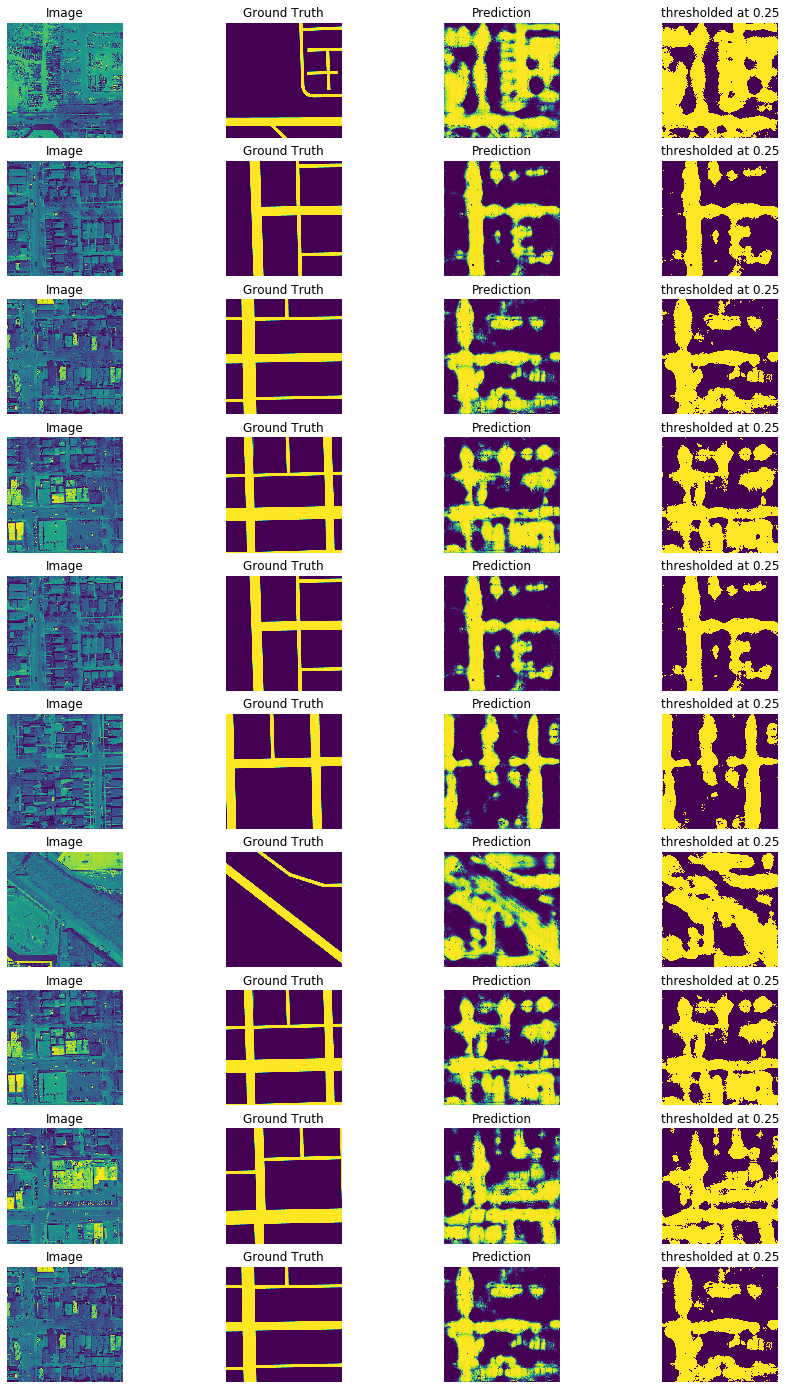

In [84]:
thresh_val = 0.25
predicton_threshold = (predictions > thresh_val).astype(np.uint8)

ix = random.randint(0, len(predictions) - 1)
num_samples = 10

f = plt.figure(figsize = (15, 25))
for i in range(1, num_samples*4, 4):
  ix = random.randint(0, len(predictions))

  f.add_subplot(num_samples, 4, i)
  plt.imshow(test_images[ix][:,:,0])
  plt.title("Image")
  plt.axis('off')

  f.add_subplot(num_samples, 4, i+1)
  plt.imshow(np.squeeze(test_label[ix][:,:,0]))
  plt.title("Ground Truth")
  plt.axis('off')

  f.add_subplot(num_samples, 4, i+2)
  plt.imshow(np.squeeze(predictions[ix][:,:,0]))
  plt.title("Prediction")
  plt.axis('off')

  f.add_subplot(num_samples, 4, i+3)
  plt.imshow(np.squeeze(predicton_threshold[ix][:,:,0]))
  plt.title("thresholded at {}".format(thresh_val))
  plt.axis('off')

plt.show()